In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA, LatentDirichletAllocation as LDA
import plotly_express as px

## PCA

In [2]:
TFIDF_L2 = pd.read_csv('TFIDF_L2.csv')
TFIDF_L2.set_index('review_id', inplace=True)

LIB = pd.read_csv('LIB.csv')
LIB.set_index('review_id', inplace=True)

VOCAB = pd.read_csv('VOCAB.csv')
VOCAB.set_index('term_str', inplace=True)

In [3]:
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    
    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)
    
    LIB_COLS = ['Genre']

    DCM = DCM.join(LIB[LIB_COLS], on='review_id')

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    LOADINGS = LOADINGS.join(VOCAB['max_pos_group'], on='term_str')
    
    return LOADINGS, DCM, COMPINF

In [4]:
tf_method = 'max'
global_term_sig = 'dfidf'
n_comps = 10
center_by_mean=False
center_by_variance=False

In [5]:
LOADINGS, DCM, COMPINF = get_pca(TFIDF_L2, 
                                 norm_docs=True, 
                                 norm_level=2, 
                                 center_by_mean=center_by_mean, 
                                 center_by_variance=center_by_variance)

In [6]:
COMPINF

pos                                 neg  \
pc_id                                                                          
0        show episode series episodes tv      horror movie film movies films   
1             film films man family wife     movie movies show horror acting   
2            horror film gore films show        movie love story book movies   
3      film films actors book characters       movie movies love horror girl   
4        action version game book script       love horror story show family   
5          action comedy show scene film    book version series novel horror   
6           music film comedy waste show  series action character man scenes   
7          love music movies cast series      book plot nothing waste people   
8         series waste film people money        book show action comedy cast   
9        comedy series cast horror laugh        music action show game thing   

        eig_val   exp_var  
pc_id                      
0      0.004420  0.140866  
1      0.003825  0.121884  
2      0.003490  0.111237  
3      0.003219  0.102586  
4      0.003043  0.096973  
5      0.002948  0.093958  
6      0.002751  0.087662  
7      0.002677  0.085309  
8      0.002547  0.081181  
9      0.002458  0.078345

In [7]:
COMPINF.to_csv('COMPINF.csv')

In [8]:
DCM

0         1         2         3         4         5  \
review_id                                                               
0         -0.053008 -0.021729  0.001298  0.136134 -0.008419  0.095836   
1         -0.088301 -0.151074  0.011743 -0.019143 -0.164854  0.131831   
2         -0.002659 -0.019702 -0.027265  0.002073 -0.032592  0.006549   
3         -0.079139 -0.004515 -0.046749  0.133463 -0.147672  0.039323   
4         -0.018683  0.039383 -0.022314  0.017790 -0.072190  0.050679   
...             ...       ...       ...       ...       ...       ...   
4995      -0.042214 -0.021754 -0.062480  0.064923 -0.090443  0.005819   
4996       0.043224  0.010398 -0.036807  0.059037 -0.119279  0.035016   
4997      -0.025561 -0.049382 -0.026133 -0.029004 -0.031365  0.005149   
4998      -0.020309  0.018695 -0.001995  0.068806  0.007840 -0.039985   
4999       0.052800 -0.104308 -0.058509  0.031455 -0.140368  0.050713   

                  6         7         8         9      Genre  
review_id                                                     
0         -0.111320 -0.053952 -0.054457 -0.064600      Drama  
1         -0.017777 -0.069763 -0.104938  0.117840  Biography  
2         -0.004644 -0.036541  0.015537 -0.023780      Drama  
3          0.034945  0.023808  0.063768 -0.018788     Comedy  
4         -0.080642 -0.087854 -0.010525 -0.047674     Comedy  
...             ...       ...       ...       ...        ...  
4995       0.015931  0.014969  0.044036  0.033678  Biography  
4996      -0.028319  0.021463 -0.038494 -0.017315     Action  
4997       0.015343 -0.036381  0.027578 -0.031270     Comedy  
4998       0.001876 -0.005247  0.006247 -0.006810     Comedy  
4999      -0.077978 -0.080003 -0.051721 -0.108461      Adult  

[5000 rows x 11 columns]

In [9]:
DCM.to_csv('DCM.csv')

In [10]:
LOADINGS

0         1         2         3         4         5  \
term_str                                                                 
time       -0.021184 -0.086733 -0.075655  0.054484 -0.039603  0.002144   
story      -0.091885 -0.045829 -0.156552  0.170148 -0.209822 -0.147981   
people     -0.009421 -0.048340 -0.037565 -0.013946 -0.130084  0.018840   
way        -0.017966 -0.031661 -0.066343  0.028566 -0.069533  0.033914   
movies     -0.149817 -0.317945 -0.138232 -0.122660 -0.069545  0.004046   
...              ...       ...       ...       ...       ...       ...   
entrance    0.000725  0.000984 -0.000783  0.000624 -0.000443  0.002239   
flashlight -0.000617  0.000707  0.000371  0.000611  0.003457  0.001982   
pigs       -0.001898  0.001596  0.002723  0.002712 -0.002440  0.002856   
vie         0.000651 -0.000374 -0.001276 -0.000364  0.001132  0.002933   
lass        0.000769  0.003551  0.000377 -0.000457  0.000499  0.000911   

                   6         7         8         9 max_pos_group  
term_str                                                          
time        0.025923 -0.037061  0.121775 -0.003111            NN  
story      -0.052543  0.091376 -0.067923 -0.037224            NN  
people      0.030880 -0.112740  0.150746 -0.057534            NN  
way        -0.033956 -0.099407  0.039097 -0.054056            NN  
movies     -0.072784  0.159286  0.075473  0.107171            NN  
...              ...       ...       ...       ...           ...  
entrance    0.000979  0.000998 -0.001684  0.002081            NN  
flashlight  0.000959 -0.002433  0.000482 -0.002849            NN  
pigs        0.000234 -0.005311  0.001264 -0.002628            NN  
vie         0.000858 -0.000079 -0.001737  0.001775            NN  
lass       -0.001060  0.000493 -0.001602  0.000405            NN  

[5000 rows x 11 columns]

In [11]:
LOADINGS.to_csv('LOADINGS.csv')

In [12]:
def vis_pca(M, a, b, label='Genre', hover_name='Genre', symbol=None, size=None):
    return px.scatter(M, x=a, y=b,
                     color=label,
                     hover_name=hover_name,
                     symbol=symbol, size=size,
                     marginal_x='box', height=600)

def vis_loadings(a, b, hover_name='term_str'):
    X = LOADINGS.join(TFIDF_L2)
    return px.scatter(X.reset_index(), a, b,
                     text='term_str', color='max_pos_group',
                     marginal_x='box', height=600)

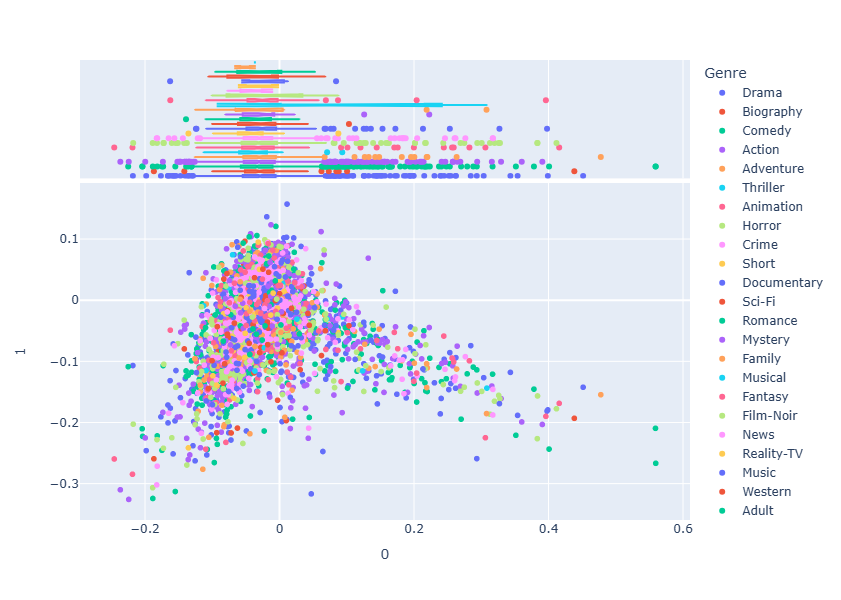

In [13]:
vis_pca(DCM, 0, 1, label='Genre')

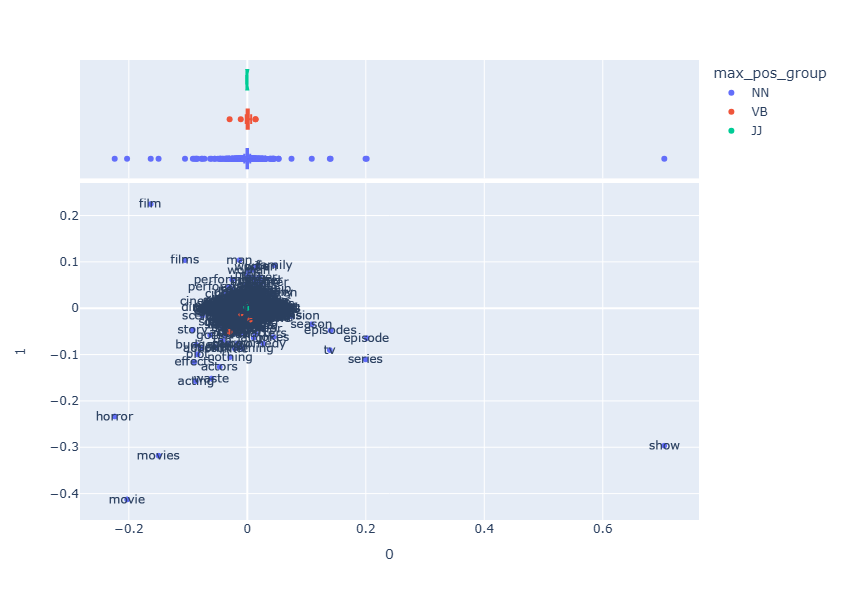

In [14]:
vis_loadings(0,1)

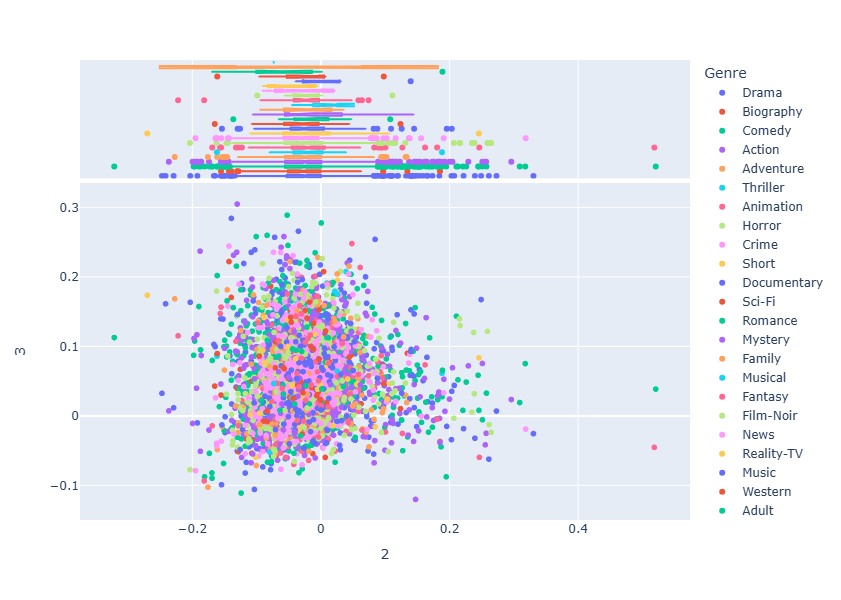

In [15]:
vis_pca(DCM, 2, 3, label='Genre')

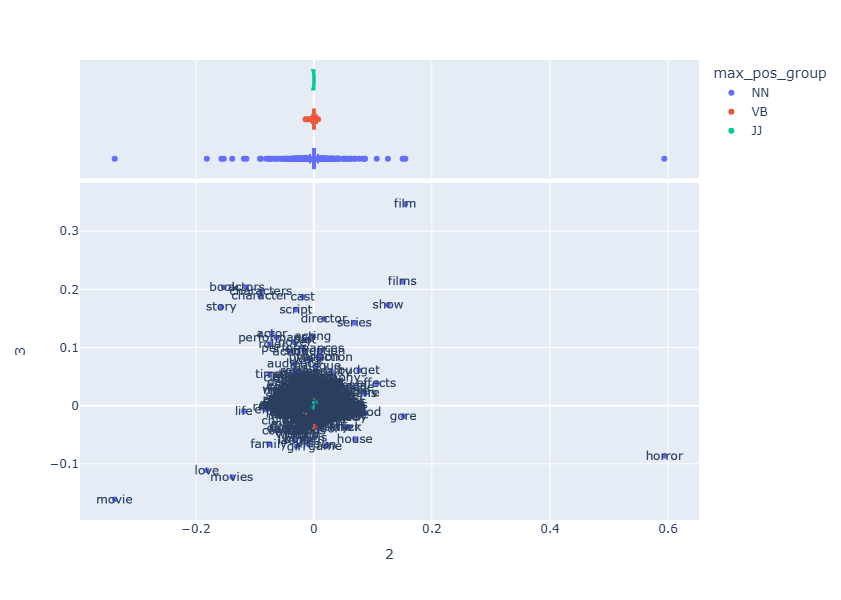

In [16]:
vis_loadings(2,3)